# From the tied array to likelihood based on the [SeeKAT method](https://arxiv.org/abs/2302.09812)

Tied array code is nicely developed by Brad. Now let's use it for a test case to develope the likelihood.

## Prerequisites

In [1]:
# For basic algebra and stats
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize

# For inference
#import pymc as pm

# For visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
import cmasher as cms
import arviz as az

# Setting latex fonts in Matplotlib
rc('text', usetex=True)
rc('font', family='serif')

# Version check and print
from print_versions import print_versions
print_versions(globals())

numpy==1.23.1
scipy==1.8.1
matplotlib==3.5.2
cmasher==1.6.3
arviz==0.12.1


## Data - tied array beams

This is the data behind $T(\hat{q})$ which is defined in eq. 6 in the paper.

Command behind the data used here:

```bash
export MWA_BEAM_FILE=../data/mwa_full_embedded_element_pattern.h5

wa_tab_loc -m ../data/1253471952.metafits -f 155000000 -t "2019-11-19T17:59:50" -L "04:52:41.10_-34:21:11.10 04:51:47.06_-34:21:11.10 04:52:14.13_-34:11:21.12 04:52:14.02_-34:31:01.07 04:51:20.20_-34:11:21.12 04:51:19.99_-34:31:01.07" --gridbox "04:46:00 -33:30:00 04:58:00 -35:10:00 5 5" --plot
```

Data are just numpy arrays, saved in `npy` and `npz` formats for quick load.

**Note**: We are only dealing with single-frequency data for the moment.


In [2]:
def data_reader(tabp_file, grid_file):
    tabp_look = np.load(tabp_file)
    print("Selecing the first frequency and ignoring all other frequencies")
    tabp_look = tabp_look[:,0,:,:]
    grid_ra = np.load(grid_file)['arr_0']
    grid_dec = np.load(grid_file)['arr_1']
    #product = np.sum(tabp_look.mean(axis=1), axis=0)
    print('tabp dimensions:', tabp_look.shape)
    #print('product dimensions:', product.shape)
    print('RA/Dec grid dimensions:', grid_ra.shape, grid_dec.shape)
    
    return tabp_look, grid_ra, grid_dec


TABP_LOOK, GRID_RA, GRID_DEC = data_reader('./tabp_look.npy', './grid.npz')

Selecing the first frequency and ignoring all other frequencies
tabp dimensions: (6, 1225, 1766)
RA/Dec grid dimensions: (1225, 1766) (1225, 1766)


## EDA

Visualizing the beams:

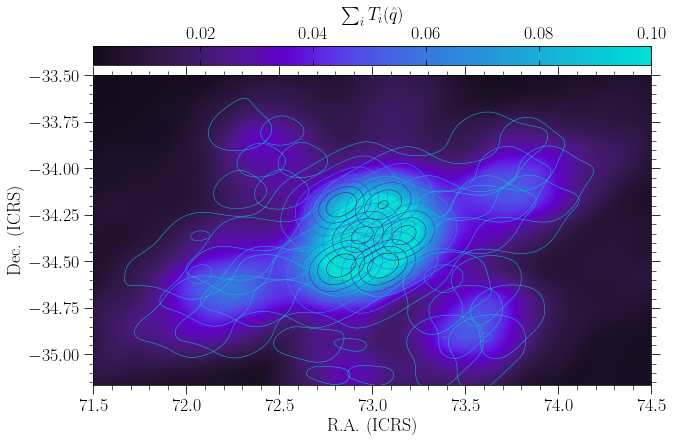

In [3]:
def eda_plot(tabp, grid_ra, grid_dec,label, contours=True):
    tabp_sum = np.sum(tabp, axis=0)

    map_extent = [grid_ra.min(),
                  grid_ra.max(),
                  grid_dec.min(),
                  grid_dec.max()]
    
    aspect = 'equal'    

    cmap = cms.get_sub_cmap(cms.cosmic,0.1,0.9)
    contour_cmap = cms.get_sub_cmap(cms.cosmic_r,0.1,0.9)
    cmapnorm_sum = colors.Normalize(vmin=1e-3, vmax=0.1, clip=True)
    cmapnorm_indiv = colors.Normalize(vmin=1e-3, vmax=0.05, clip=True)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1_img = ax1.imshow(tabp_sum,
                         aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm_sum)

    #ls_list = ['-','--',':','-.',(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5))]
    #ls_list = ['-','--',':','-.','-','--']
    if contours:
        for ls, look in enumerate(tabp):
            ct = ax1.contour(look, origin='image', extent=map_extent, cmap=contour_cmap, norm=cmapnorm_indiv, linewidths=0.5)

    ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
    ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='major', length=9)
    ax1.tick_params(axis='both', which='minor', length=4.5)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)

    cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=1, orientation='horizontal',location='top', aspect=30, pad=0.02)
    cbar.ax.set_title(label,fontsize=18,ha='center')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(direction='in',length=5,bottom=True,top=True)
    cbar.ax.xaxis.set_tick_params(labelsize=18)
    return fig, ct

eda_plot(TABP_LOOK, GRID_RA, GRID_DEC, r'$\sum_i T_i(\hat{q})$');

#### The background colormap represents the sum over all look directions. The contour lines are vague representation of individual look directions.

In [4]:
OBS_SNR = np.array([13,26,21,10,8,8]) #[:,None,None,None]
OBS_MASK = OBS_SNR<OBS_SNR.max()
OBS_WEIGHTS = OBS_SNR[OBS_MASK]/OBS_SNR.max()

In [5]:
N_SIM = 1000
SIMULATION_SNR = st.multivariate_normal(OBS_SNR).rvs(N_SIM)
SIMULATION_RATIO = SIMULATION_SNR[:,OBS_MASK]/SIMULATION_SNR.T[OBS_SNR.argmax()][:,None]

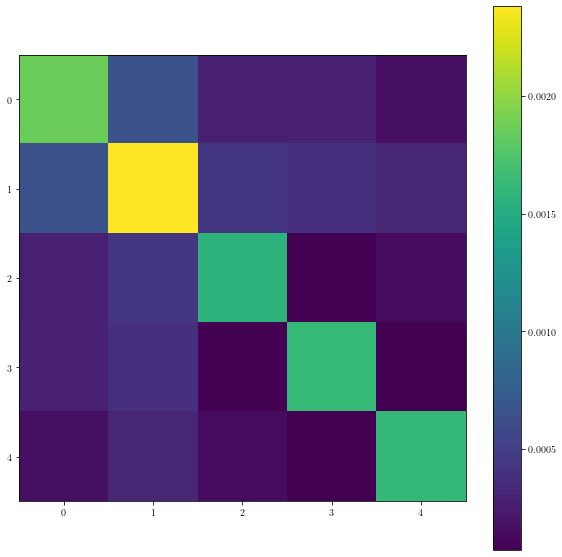

In [6]:
#DELTA = SIMULATION-OBS_WEIGHTS[None,:]
#SIM_COV = np.dot(DELTA.T,DELTA)/(N_SIM-1)
SIM_COV = np.cov(SIMULATION_RATIO,rowvar=False)
plt.figure(figsize=(10,10))
plt.imshow(SIM_COV)
plt.colorbar()

In [7]:
P_array = TABP_LOOK[OBS_MASK,...]/TABP_LOOK[OBS_SNR.argmax(),...]
R_array = OBS_WEIGHTS[:,None,None]-P_array

In [8]:
## Chi2 calc
SIM_COV_INV = np.linalg.inv(SIM_COV)
INNER_PROD = np.einsum("ij,jkN->ikN", SIM_COV_INV, R_array)
OUTER_PROD = np.einsum("ijN,Njk->ji", R_array.T, INNER_PROD)
LogLike = -0.5*OUTER_PROD

/tmp/ipykernel_391076/3328266442.py:16: RuntimeWarning: invalid value encountered in log10
  ax1_img = ax1.imshow(np.log10(LogLike),


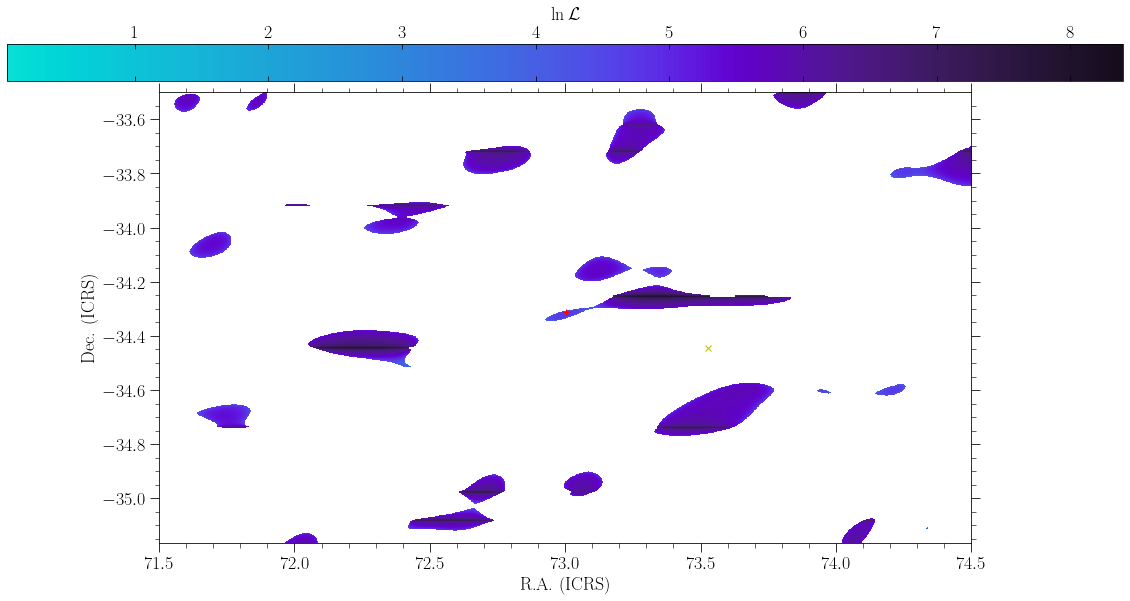

In [9]:
map_extent = [GRID_RA.min(),
              GRID_RA.max(),
              GRID_DEC.min(),
              GRID_DEC.max()]

aspect = 'equal'    

cmap = cms.get_sub_cmap(cms.cosmic_r,0.1,0.9)
#cmapnorm = colors.LogNorm(vmin=1e-10, vmax=1e16, clip=False)
cmapnorm = colors.Normalize()


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)

ax1_img = ax1.imshow(np.log10(LogLike),
                     aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm)
ax1.plot(73.0029167, -34.3116667, '+r')

best_pix_x, best_pix_y = np.unravel_index(np.argmin(LogLike),LogLike.shape)
best_ra, best_dec = GRID_RA[best_pix_x, best_pix_y], GRID_DEC[best_pix_x, best_pix_y]


ax1.plot(best_ra, best_dec,'xy')

#ax1.set_title('Example Source Synth. Beam', fontsize=18, pad=20)
ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='major', length=9)
ax1.tick_params(axis='both', which='minor', length=4.5)
ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)

cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=1, orientation='horizontal',location='top', aspect=30, pad=0.02)
cbar.ax.set_title(r'$\ln\mathcal{L}$',fontsize=18,ha='center')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(direction='in',length=5,bottom=True,top=True)
cbar.ax.xaxis.set_tick_params(labelsize=18)
